In [1]:
# pip install openneuro-py
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import openneuro

from ndspflow.workflows.workflow import WorkFlow

from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF, FOOOFGroup
from bycycle import Bycycle

/var/folders/fm/pn7dn_wn7mz0nw0h4v1_5p840000gn/T/ipykernel_60987/868293528.py:13: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


# BIDS WorkFlow

Below, we fetch a BIDS dataset using the openneuro cli. Then define and execute the following workflow:

1. Load the BIDS directory using MNE BIDS
2. Apply custom functions to select channels and epoch the signal
3. Low-pass filter with neurodsp
4. Fit FOOOF
5. Fit Bycycle

In [2]:
%%capture
dataset = 'ds003844'
include = ['sub-RESP0059/ses-SITUATION1A', 'sub-RESP0280/ses-SITUATION1A']

# Create BIDs folder
bids_path = f'{os.getcwd()}/bids'

if not os.path.isdir(bids_path):
    os.makedirs(bids_path)
    
openneuro.download(dataset=dataset, target_dir=bids_path, include=include)

In [3]:
def select_channels(y_array, channels):
    """Select sub-set of channels."""
    return y_array[channels]
    
def epoch(y_array, n_epochs, epoch_len):
    """Epoch function."""
    y_array = y_array[:, :int(n_epochs) * epoch_len]
    y_array = y_array.reshape(-1, epoch_len)
    
    return y_array

In [4]:
wf = WorkFlow(bids_path=bids_path, session='SITUATION1A', task='acute')

wf.read_bids(subject='sub-RESP0059', allow_ragged=True)

# Custom transforms
wf.transform(select_channels, [0, 1])
wf.transform(epoch, 2, 5000)
wf.transform(filter_signal, 'self.fs', 'lowpass', 200, remove_edges=False)

wf.fork(0)
wf.transform(compute_spectrum, 'self.fs')
wf.fit(FOOOF(verbose=False, max_n_peaks=5), (1, 100), axis=-1)

wf.fork(0)
wf.fit(Bycycle(thresholds={"amp_consistency": 0.8}), 'self.fs', (50, 100), axis=-1)

wf.run(n_jobs=1, progress=tqdm)

## Inspecting Workflows
Preprocessing workflows may be inspected by calling `.run()` with no `.fit()` defined in the workflow. The resulting array (`.y_array`) is collected below, from a series of `.transform()` calls.

In [5]:
wf = WorkFlow(bids_path=bids_path, session='SITUATION1A', task='acute')

wf.read_bids(subject='sub-RESP0059', allow_ragged=True)


wf.transform(select_channels, [0, 1])
wf.transform(epoch, 2, 5000)
wf.transform(filter_signal, 'self.fs', 'lowpass', 200, remove_edges=False)

wf.run()

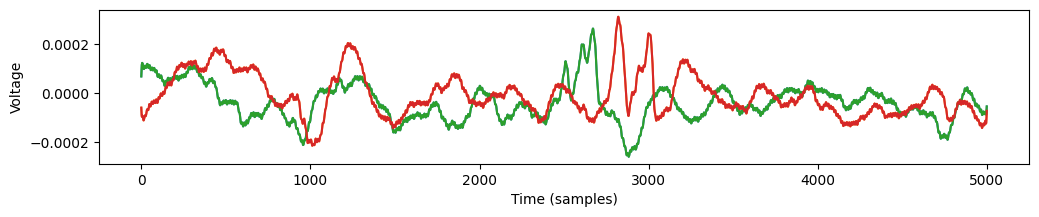

In [6]:
# Plot example channels
plt.figure(figsize=(12, 2))
for subj in wf.y_array:
    for ch in subj[2:]:
        plt.plot(ch)
        
plt.ylabel('Voltage')
plt.xlabel('Time (samples)');